In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, ChainDataset
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv3d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(540, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool3d(self.conv1(x), 2))
        x = F.relu(F.max_pool3d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 540)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
realImages = np.load("originalSubsets.npy")
realImages.shape

(1967, 20, 20, 20)

In [5]:
fakeImages = np.load("rescaledSubsets.npy")
fakeImages.shape

(1967, 20, 20, 20)

In [6]:
import random
random.shuffle(realImages)
random.shuffle(fakeImages)

In [7]:
def addInfoToList(imageList, label, dataList):
    for image in imageList:
        dataList.append((image,label))

def getDataLoaderFromList(dataList):
    return DataLoader(dataList, shuffle=True)

In [8]:
trainData = []

trainDataSize = len(realImages) //2

addInfoToList(realImages[:trainDataSize], 0., trainData)

addInfoToList(fakeImages[:trainDataSize], 1., trainData)

print(len(trainData))

1966


In [9]:
validateData = []

validateDataSize = len(realImages) //4
validateDataSize +=trainDataSize
addInfoToList(realImages[trainDataSize: validateDataSize], 0., validateData)
addInfoToList(fakeImages[trainDataSize: validateDataSize], 1., validateData)

print(len(validateData))

982


In [10]:
testData = []

addInfoToList(realImages[validateDataSize:], 0., testData)
addInfoToList(fakeImages[validateDataSize:], 1., testData)
print(len(testData))

986


In [11]:
trainData = getDataLoaderFromList(trainData)

validateData = getDataLoaderFromList(validateData)

testData = getDataLoaderFromList(testData)

In [12]:
def getAccuracyFromModel(model, dataSet):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img,label in dataSet:
            img, label = img.unsqueeze(0).float().to(device), label.long().to(device)
            output = model(img)
            test_loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            if pred == label:
                correct+=1
        test_loss /= len(testData)
        test_losses.append(test_loss)
        model.train()
        return float(correct/len(dataSet))


In [13]:
learning_rate = 0.001
momentum = 0.5



In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
epochList = []

trainLossList = []
trainAccuracyList = []
validationAccuracyList = []


prevAccuracy = None

for epoch in range(1, 501):
    train_loss = 0
    for batch_idx, (img, target) in enumerate(trainData):
        img, target = img.unsqueeze(0).float().to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()
    validationAccuracy = getAccuracyFromModel(model, validateData) * 100.
    trainingAccuracy = getAccuracyFromModel(model, trainData) * 100.
    
    epochList.append(epoch)
    trainLossList.append(train_loss)    
    trainAccuracyList.append(trainingAccuracy)
    validationAccuracyList.append(validationAccuracy)
    
    print("Epoch # " + str(epoch) + " Accuracy = " + str(validationAccuracy))
    if prevAccuracy is None or validationAccuracy > prevAccuracy:
        prevAccuracy = validationAccuracy
        torch.save(model, 'bestModel.pkl')





<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/alex/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch # 1 Accuracy = 51.5274949083503
Epoch # 2 Accuracy = 51.73116089613035
Epoch # 3 Accuracy = 52.85132382892057
Epoch # 4 Accuracy = 54.378818737270876
Epoch # 5 Accuracy = 58.85947046843177
Epoch # 6 Accuracy = 57.73930753564155
Epoch # 7 Accuracy = 54.276985743380855
Epoch # 8 Accuracy = 53.462321792260695
Epoch # 9 Accuracy = 59.47046843177189
Epoch # 10 Accuracy = 57.63747454175153
Epoch # 11 Accuracy = 53.66598778004074
Epoch # 12 Accuracy = 55.397148676171085
Epoch # 13 Accuracy = 58.35030549898167
Epoch # 14 Accuracy = 67.92260692464357
Epoch # 15 Accuracy = 74.33808553971487
Epoch # 16 Accuracy = 65.88594704684317
Epoch # 17 Accuracy = 80.04073319755601
Epoch # 18 Accuracy = 68.0244399185336
Epoch # 19 Accuracy = 78.00407331975559
Epoch # 20 Accuracy = 77.08757637474541
Epoch # 21 Accuracy = 79.93890020366598
Epoch # 22 Accuracy = 80.5498981670061
Epoch # 23 Accuracy = 76.57841140529531
Epoch # 24 Accuracy = 79.0224032586558
Epoch # 25 Accuracy = 57.5356415478615
Epoch # 26

Epoch # 205 Accuracy = 97.75967413441956
Epoch # 206 Accuracy = 97.45417515274949
Epoch # 207 Accuracy = 98.26883910386965
Epoch # 208 Accuracy = 97.35234215885947
Epoch # 209 Accuracy = 98.06517311608961
Epoch # 210 Accuracy = 95.31568228105907
Epoch # 211 Accuracy = 97.25050916496944
Epoch # 212 Accuracy = 98.16700610997964
Epoch # 213 Accuracy = 97.5560081466395
Epoch # 214 Accuracy = 97.35234215885947
Epoch # 215 Accuracy = 92.26069246435846
Epoch # 216 Accuracy = 97.25050916496944
Epoch # 217 Accuracy = 97.5560081466395
Epoch # 218 Accuracy = 96.94501018329939
Epoch # 219 Accuracy = 97.86150712830958
Epoch # 220 Accuracy = 97.04684317718942
Epoch # 221 Accuracy = 97.5560081466395
Epoch # 222 Accuracy = 97.35234215885947
Epoch # 223 Accuracy = 96.33401221995926
Epoch # 224 Accuracy = 97.5560081466395
Epoch # 225 Accuracy = 97.86150712830958
Epoch # 226 Accuracy = 97.65784114052953
Epoch # 227 Accuracy = 97.35234215885947
Epoch # 228 Accuracy = 94.70468431771894
Epoch # 229 Accuracy

Epoch # 406 Accuracy = 98.98167006109979
Epoch # 407 Accuracy = 98.98167006109979
Epoch # 408 Accuracy = 98.57433808553971
Epoch # 409 Accuracy = 98.57433808553971
Epoch # 410 Accuracy = 97.75967413441956
Epoch # 411 Accuracy = 96.5376782077393
Epoch # 412 Accuracy = 98.37067209775967
Epoch # 413 Accuracy = 98.57433808553971
Epoch # 414 Accuracy = 98.67617107942974
Epoch # 415 Accuracy = 98.06517311608961
Epoch # 416 Accuracy = 97.5560081466395
Epoch # 417 Accuracy = 98.98167006109979
Epoch # 418 Accuracy = 98.87983706720978
Epoch # 419 Accuracy = 98.87983706720978
Epoch # 420 Accuracy = 98.37067209775967
Epoch # 421 Accuracy = 98.37067209775967
Epoch # 422 Accuracy = 99.08350305498982
Epoch # 423 Accuracy = 97.25050916496944
Epoch # 424 Accuracy = 98.57433808553971
Epoch # 425 Accuracy = 98.16700610997964
Epoch # 426 Accuracy = 98.57433808553971
Epoch # 427 Accuracy = 98.37067209775967
Epoch # 428 Accuracy = 98.37067209775967
Epoch # 429 Accuracy = 98.67617107942974
Epoch # 430 Accura

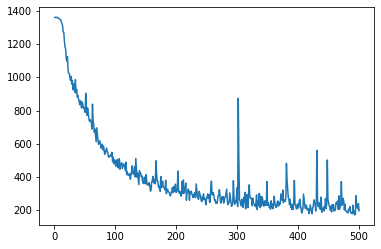

In [16]:
plt.plot(epochList, trainLossList)

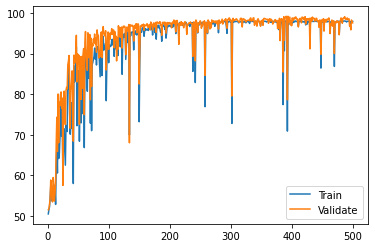

In [17]:
plt.plot(epochList, trainAccuracyList, label= "Train")
plt.plot(epochList, validationAccuracyList, label = "Validate")
plt.legend()
plt.show()

In [18]:
model = torch.load('bestModel.pkl')
accuracy = getAccuracyFromModel(model, testData) * 100.
print("Accuracy on testData " + str(accuracy))


<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy on testData 98.58012170385395
